## 1. Find the camera matrix and distortion Co-efficients

In [2]:
# import essential modules
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib qt
%matplotlib inline

In [3]:
def camera_calibration(directory_path=None):
    assert directory_path, "Please provide directory Path"
    
    path_calibration = directory_path
    calibration_images = os.listdir(path_calibration)

    obj_point_list = []
    img_point_list = []

    #Getting Objectpoints 
    obj_points = np.zeros((9*6,3), np.float32)
    obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    #iterating through all images in the folder 
    for image in calibration_images:
        # generate the actual path of the image
        img_path = os.path.join(path_calibration, image)
        img = mpimg.imread(img_path)
        # convert the image to gray scale as the findChessboardCorners takes only gray scale images
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
        if ret:
            obj_point_list.append(obj_points)
            img_point_list.append(corners)

    # get the camera matrix and distorted matrix
    return cv2.calibrateCamera(obj_point_list, img_point_list, gray.shape[::-1], None, None)

ret, mtx, dist, rvec, tvec = camera_calibration("camera_cal/")



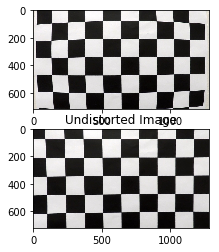

In [4]:
def undistort_image(image_path, camera_matrix, distortion_matrix):
    # Read the image
    img = mpimg.imread(image_path)
    # Apply the camera matrix and distortion matrix to undistort the given image
    return cv2.undistort(img, camera_matrix, distortion_matrix, None, camera_matrix)

plt.subplot(211)
plt.imshow(mpimg.imread("camera_cal/calibration1.jpg"))
undistorted_img = undistort_image("camera_cal/calibration1.jpg", mtx, dist)
plt.subplot(212)
plt.title("Undistorted Image")
plt.imshow(undistorted_img)

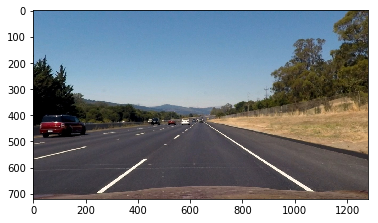

In [6]:
image_path = 'test_images/straight_lines2.jpg'
undistorted_original = undistort_image(image_path, mtx, dist)
plt.imshow(undistorted_original)

## Apply Color and Gradient Threshold

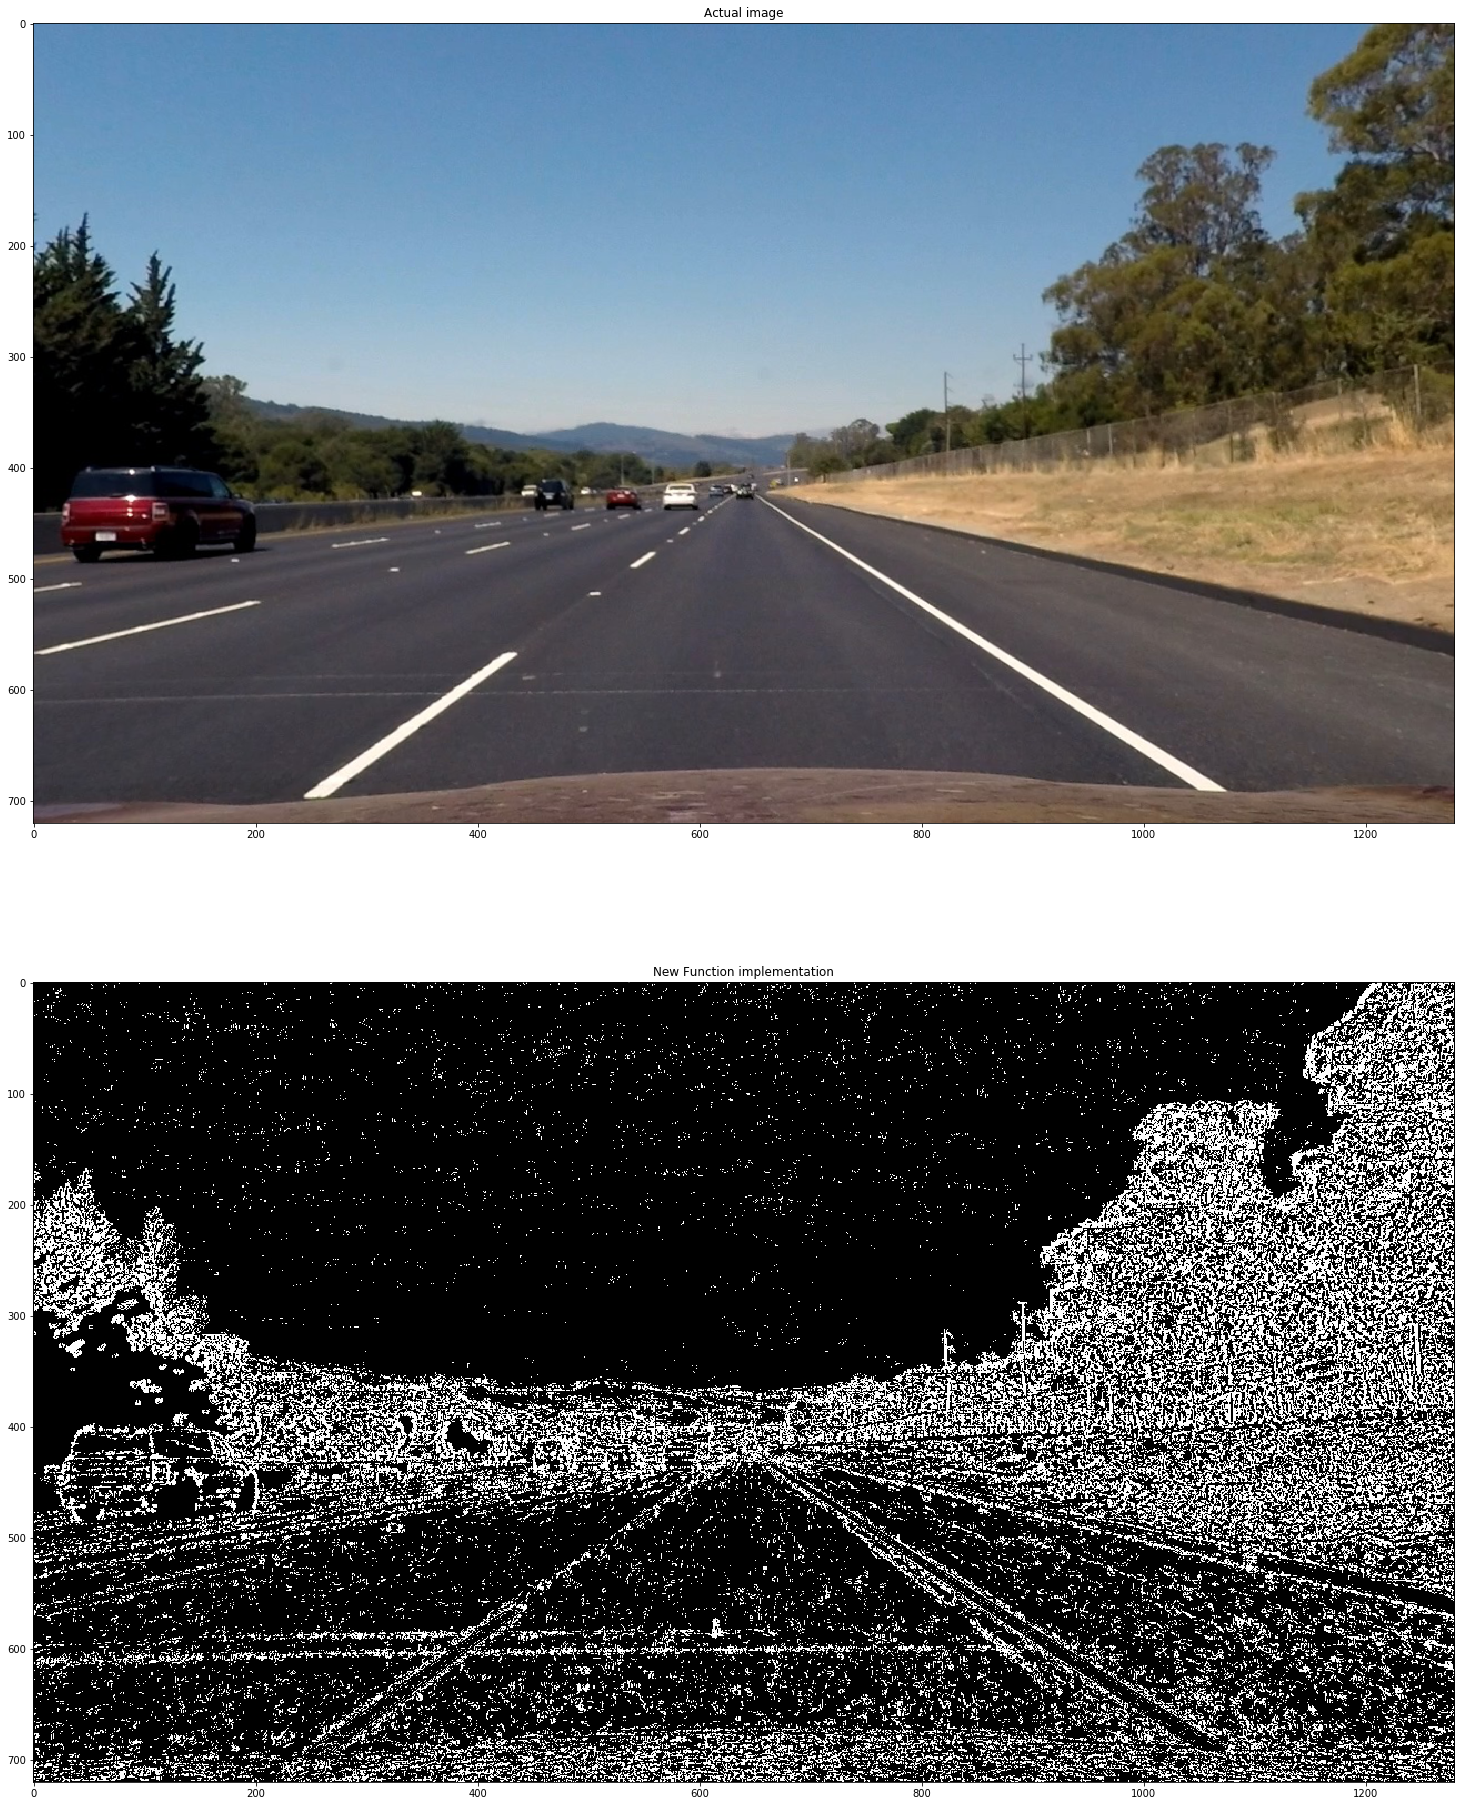

In [9]:
plt.figure(figsize=(40,50))

plt.subplot(211)
plt.title("Actual image")
plt.imshow(undistorted_original)

def apply_adaptive_thresholding(undistorted_color_image, channel_index_in_hls=2, kernel_size=9, correction=2):
    hls = cv2.cvtColor(undistorted_color_image, cv2.COLOR_RGB2HLS)
    return cv2.adaptiveThreshold(hls[:,:,channel_index_in_hls], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, kernel_size, correction)


def get_sobel_xy(gray, x=0, y=0, kernel_size=3):
    assert x == 1 or y == 1, "Please select to apply sobel in either x direction or y direction"
    return cv2.Sobel(gray, cv2.CV_64F, x,y, kernel_size)


def apply_magnitude_thresholding(gray_img, sobel_x, sobel_y, threshold=(5,125)):
    #Get Absolute threshold
    absolute_sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    #scaled thresholding
    scaled_sobel = np.uint8(255 * absolute_sobel/ np.max(absolute_sobel))
    binary_scaled = np.zeros_like(scaled_sobel)
    # Apply the thresholds
    binary_scaled[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    return binary_scaled


def apply_orientation_thresholding(sobel_x, sobel_y, threshold=(0,1.45)):
    #Direction threholding
    orientation = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_orient = np.zeros_like(orientation)
    # Apply the thresholds
    binary_orient[(orientation >= threshold[0]) & (orientation <= threshold[1])] = 1
    return binary_orient


def get_magnitude_orientation_threshold(mag_binary_img, orient_binary_img):
    combined = np.zeros_like(orient_binary_img)
    combined[(orient_binary_img == 1) & (mag_binary_img == 1)] =1
    return combined


def combine_threshold_img(color_threshold, mag_orient_threshold_img):
    gradient = np.zeros_like(mag_orient_threshold_img)
    gradient[(color_threshold == 1) & (mag_orient_threshold_img ==1)] =1
    return gradient


color_threshold_img = apply_adaptive_thresholding(undistorted_original)
gray_img = cv2.cvtColor(undistorted_original, cv2.COLOR_RGB2GRAY)
sobel_x = get_sobel_xy(gray_img, 1,0)
sobel_y = get_sobel_xy(gray_img, 0,1)
magnitude_threshold_img = apply_magnitude_thresholding(gray_img, sobel_x, sobel_y)
orientation_threshold_img = apply_orientation_thresholding(sobel_x, sobel_y)
binary_image_threshold = get_magnitude_orientation_threshold(magnitude_threshold_img, orientation_threshold_img)
threshold_img = combine_threshold_img(color_threshold_img, binary_image_threshold)

plt.subplot(212)
plt.title("New Function implementation")
plt.imshow(threshold_img, cmap='gray')

## Performing Perspective Transformation of the image

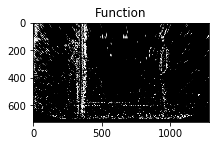

In [66]:
plt.figure(figsize=(30,30))
def get_src_dst_for_warp(undistorted_bin_img):
    h,w = undistorted_bin_img.shape
    # Constants defined to make the transformation independentent of image size
    midpoint = w // 2
    offset_midpoint = 130
    height_low = h //2 + 115
    height_hight = h - 50
    offset = 50
    
    src = np.array([[midpoint-offset_midpoint, height_low],[midpoint+offset_midpoint, height_low],
                [midpoint+4.2*offset_midpoint, height_hight],[midpoint-4.2*offset_midpoint, height_hight]], np.float32)


#     dst = np.array([[midpoint-3.7*offset_midpoint, offset],[midpoint+3.7*offset_midpoint, offset],
#                     [midpoint+3.45*offset_midpoint, height_hight],[midpoint-3.45*offset_midpoint, height_hight]], np.float32)
    
    dst = np.array([[offset, offset],[w - offset, offset],
                    [w - offset, height_hight],[offset, height_hight]], np.float32)
    
#     plt.subplot(211)
#     plt.scatter(midpoint-offset_midpoint, height_low, color='red')
#     plt.scatter(midpoint+offset_midpoint, height_low, color='green')
#     plt.scatter(midpoint+4.2*offset_midpoint, height_hight, color='white')
#     plt.scatter(midpoint-4.2*offset_midpoint, height_hight, color='blue')

#     plt.scatter(20, offset, color='red')
#     plt.scatter(w-20, offset, color='green')
#     plt.scatter(w-20, height_hight, color='white')
#     plt.scatter(20, height_hight, color='blue')
#     plt.imshow(undistorted_bin_img, cmap='gray')
    return src,dst
    
def apply_perspective_transform(undistorted_bin_img, src, dst):
    h,w = undistorted_bin_img.shape
    M = cv2.getPerspectiveTransform(src,dst)
    return cv2.warpPerspective(undistorted_bin_img, M, (w,h), cv2.INTER_LINEAR)

src, dst = get_src_dst_for_warp(threshold_img)
warp_img = apply_perspective_transform(threshold_img, src, dst)


plt.subplot(212)
plt.title("Function")
plt.imshow(warp_img, cmap='gray')

## Finding Lane Lines

### 1. Finding Lane Lines for the First Frame

In [65]:
def get_initial_pixel_values(warp_img):
    #Get the histogram for just the bottom part of the image
    hist = np.sum(warp_img[warp_img.shape[0]//2:, :], axis=0)
    midpoint = len(hist) // 2
    left = np.argmax(hist[: midpoint])
    right = np.argmax(hist[midpoint :]) + midpoint
    return left, right
print("Initial left and right pixel indices: {}".format(get_initial_pixel_values(warp_img)))

Initial left and right pixel indices: (357, 944)


#### It was found that the difference between the lane lines in Warped Image for the Current transfom is 600pixels

### 2. Try to find the PolyNomial

Win Height[684, 720], left Wind[232,432], Right Wind[874,1074]
165 55
Win Height[648, 684], left Wind[257,457], Right Wind[858,1058]
716 336
Win Height[612, 648], left Wind[250,450], Right Wind[856,1056]
849 0
Win Height[576, 612], left Wind[249,449], Right Wind[856,1056]
986 0
Win Height[540, 576], left Wind[248,448], Right Wind[856,1056]
1103 0
Win Height[504, 540], left Wind[250,450], Right Wind[856,1056]
1166 120
Win Height[468, 504], left Wind[249,449], Right Wind[851,1051]
1417 306
Win Height[432, 468], left Wind[246,446], Right Wind[855,1055]
1421 0
Win Height[396, 432], left Wind[249,449], Right Wind[855,1055]
1368 0
Win Height[360, 396], left Wind[252,452], Right Wind[855,1055]
1366 58
Win Height[324, 360], left Wind[250,450], Right Wind[843,1043]
1419 961
Win Height[288, 324], left Wind[244,444], Right Wind[845,1045]
2068 1454
Win Height[252, 288], left Wind[248,448], Right Wind[850,1050]
2135 1476
Win Height[216, 252], left Wind[251,451], Right Wind[852,1052]
2093 1036
Win H

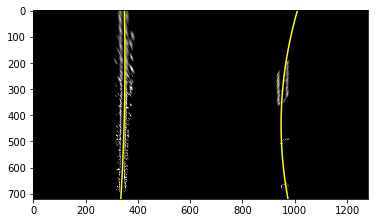

In [9]:
def search_lane_lines(warp_img, nwindows=20, minpixels=50, margin=100):
    
    left_current, right_current = get_initial_pixel_values(warp_img)
    height, width = warp_img.shape
    nonzero = np.nonzero(img)
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    left_inds = []
    right_inds = []
    
    for i in range(nwindows):
        win_height_high = height - i*window_height
        win_height_low = height - (i+1)*window_height

        win_left_min = left_current - margin
        win_left_max = left_current + margin
        win_right_min = right_current - margin
        win_right_max = right_current + margin



        left_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                             (nonzerox >= win_left_min)&(nonzerox <= win_left_max)).nonzero()[0]
        right_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                             (nonzerox >= win_right_min)&(nonzerox <= win_right_max)).nonzero()[0]

        left_inds.append(left_current_inds)
        right_inds.append(right_current_inds)

        if len(left_current_inds) > minpiixels:
            left_current =  int(np.mean(nonzerox[left_current_inds]))
        if len(right_current_inds) > minpiixels:
            right_current =  int(np.mean(nonzerox[right_current_inds]))
    
    left_inds = np.concatenate(left_inds)
    right_inds = np.concatenate(right_inds) 
    
    left_x = nonzerox[left_inds]
    left_y = nonzeroy[left_inds]
    right_x = nonzerox[right_inds]
    right_y = nonzeroy[right_inds]
    
    return left_x, left_y, right_x, right_y

def poly_fit(warp_img, left_x, left_y, right_x, right_y):
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    ploty = np.linspace(0, warp_img.shape[0]-1, warp_img.shape[0])
    left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty
    

nwindows = 20
minpiixels = 50
margin = 100
height, width = img.shape
nonzero = np.nonzero(img)
nonzerox = nonzero[1]
nonzeroy = nonzero[0]
# print(len(nonzerox), len(nonzeroy))
left_inds = []
right_inds = []
window_height = height // nwindows
for i in range(nwindows):
    win_height_high = height - i*window_height
    win_height_low = height - (i+1)*window_height
    
    win_left_min = left_current - margin
    win_left_max = left_current + margin
    win_right_min = right_current - margin
    win_right_max = right_current + margin
    print("Win Height[{}, {}], left Wind[{},{}], Right Wind[{},{}]"
          .format(win_height_low, win_height_high, win_left_min, win_left_max,
                 win_right_min, win_right_max))
    

    
    left_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                         (nonzerox >= win_left_min)&(nonzerox <= win_left_max)).nonzero()[0]
    right_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                         (nonzerox >= win_right_min)&(nonzerox <= win_right_max)).nonzero()[0]
    
    print(len(left_current_inds), len(right_current_inds))
#     print(left_current_inds.shape, right_current_inds.shape)
    left_inds.append(left_current_inds)
    right_inds.append(right_current_inds)
    
    if len(left_current_inds) > minpiixels:
        new_left =  int(np.mean(nonzerox[left_current_inds]))
        expected_left = right_current - 600
#         print("UPDATING LEFT: new_left: {}, expected_left: {}".format(new_left, expected_left))
        left_current =  int(np.mean([new_left,expected_left]))
#         print("UPDATING LEFT: Difference between Left and Right is : {}".format(right_current - left_current))
    if len(right_current_inds) > minpiixels:
        new_right = int(np.mean(nonzerox[right_current_inds]))
        expected_current = left_current + 600
#         print("\tUPDATING RIGHT: new_right: {}, expected_current: {}".format(new_right, expected_current))
        right_current =  int(np.mean([new_right,expected_current]))
#         print("\tUPDATING RIGHT:Difference between Left and Right is : {}".format(right_current - left_current))
        
left_inds = np.concatenate(left_inds)
right_inds = np.concatenate(right_inds)

        
left_x = nonzerox[left_inds]
left_y = nonzeroy[left_inds]
right_x = nonzerox[right_inds]
right_y = nonzeroy[right_inds]


left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]


# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(img, cmap='gray')

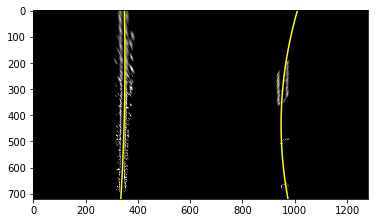

In [10]:
left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]


# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(img, cmap='gray')

In [11]:
ym_per_pix = 30/720 
xm_per_pix = 3.7/700

# Calculating the Curvature
def calculate_curvature(line_fit,y_value, multiplier=1):
    a_times_2 = 2*line_fit[0]
    y_val = np.max(y_value)*multiplier
    curvature = ((1+(a_times_2*y_val + line_fit[1])**2)**1.5) / np.absolute(a_times_2)
    return curvature

print(calculate_curvature(left_fit, ploty))
print(calculate_curvature(right_fit, ploty))

8432.27602435
1606.27393102


In [12]:
#Calculate curvature in mts

def fit_line_mts(y,x):
    line_fir = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    return line_fir

print(calculate_curvature(fit_line_mts(left_y, left_x), ploty, ym_per_pix),"m")
print(calculate_curvature(fit_line_mts(right_y, right_x), ploty, ym_per_pix),"m")

2754.11286052 m
501.977967911 m


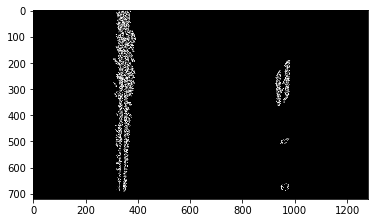

In [13]:
img_warp = warp_img
out_img = np.dstack((img_warp, img_warp, img_warp)) *255

window_img = np.zeros_like(out_img)
plt.imshow(out_img, cmap='gray')

In [ ]:
left_line_points = np.array([np.vstack((left_fitx, ploty)).T])
right_line_points = np.array([np.flipud(np.vstack((right_fitx, ploty)).T)])
lane_pts = np.hstack((left_line_points, right_line_points))

cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255,0))

result = cv2.addWeighted(out_img, 0.0, window_img, 0.99, 0)
# print(out_img.dtype)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(result)

In [ ]:
M_inv = cv2.getPerspectiveTransform(dst,src)
un_warp_img = cv2.warpPerspective(result, M_inv, (w,h))


# Due to the changes in Format in original image and unwarp image, we need to normalize the values
img_n = cv2.normalize(src=un_warp_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

actual_image_region = cv2.addWeighted(undistorted_original, 1, img_n , 0.8,0)
plt.figure(figsize=(50,50))
plt.imshow(actual_image_region)

